# Movie Genre Classification on IMDB Dataset

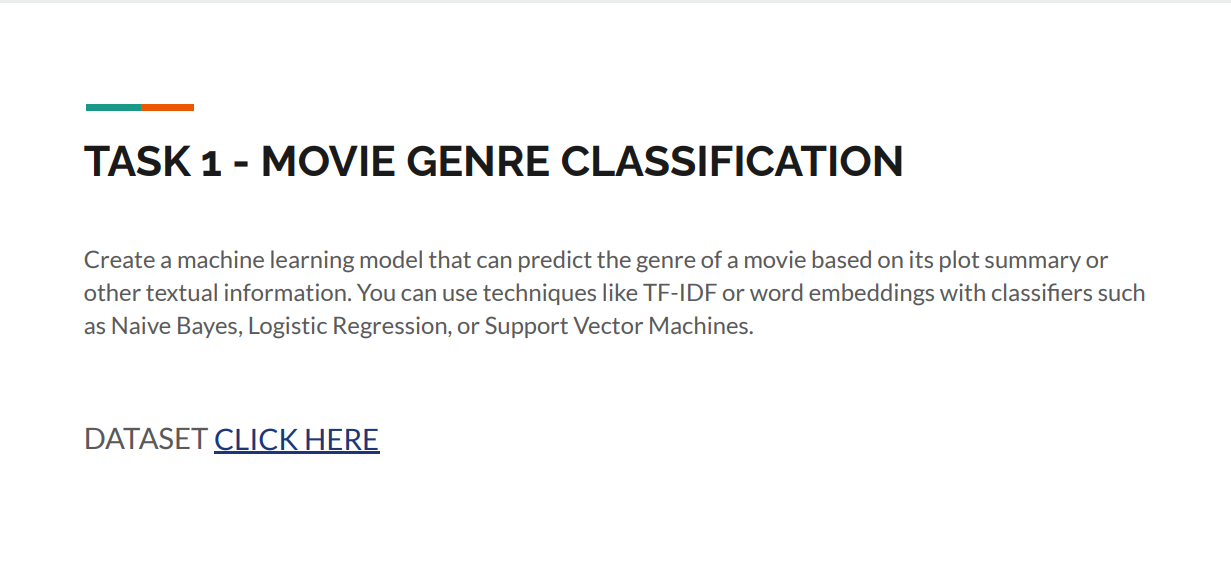

In [1]:
from IPython.display import Image
Image(filename='Project 1.png')

 ### 0. Import libraries, Read files, Define etc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
import os
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
# CountVectorizer:

# Representation: Converts text to word frequency vectors.
# Vector Elements: Counts of words in a document.
# Usage: Useful for presence/absence and frequency of words.

from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer:

# Representation: Converts text to TF-IDF feature vectors.
# Vector Elements: Considers importance of words using TF-IDF values.
# Usage: Emphasizes word importance, effective for distinguishing 

#Convert sentiment labels to numerical values for modeling
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [3]:
# read dataset
train_data = pd.read_csv("E:/NeuroNexus Internship/Project 1/archive/Genre Classification Dataset/train_data.txt", delimiter=':::' ,header = None ,engine='python')
test_data  = pd.read_csv("E:/NeuroNexus Internship/Project 1/archive/Genre Classification Dataset/test_data.txt", delimiter=':::' ,header = None ,engine='python')

test_data_solution  = pd.read_csv("E:/NeuroNexus Internship/Project 1/archive/Genre Classification Dataset/test_data_solution.txt", delimiter=':::' ,header = None ,engine='python')

In [4]:
train_data

,0,1,2,3
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [5]:
test_data

,0,1,2
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


In [6]:
# Concatenating the dataset of train and test data because the split is almost 50:50 
# It would be better if the train and test ratio is 80:20
df = pd.concat((train_data ,test_data_solution))
df.columns = ["id" ,"Title","Genre","Description"]

In [7]:
df

,id,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),adult,A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard..."


### 1. Data Cleaning

In [8]:
# Number of duplicates
dupli=df.duplicated().sum()
dupli

0

In [9]:
# if duplicates are present
df.drop_duplicates(inplace=True)

In [10]:
df.isna().sum()  # Will check for any duplicates

df.dropna( inplace = True ) ## Will drop any nan containing row if exists 

In [11]:
df.shape

(108414, 4)

In [13]:
# Function to preprocess text data
stopwords_set = set(stopwords.words('english'))

def preprocessing(text):
    """
    Preprocesses text data by performing the following steps:
    1. Converts text to lowercase.
    2. Removes punctuation using regular expressions.
    3. Removes specific characters (#, @, $).
    4. Tokenizes the text.
    5. Lemmatizes each token.
    6. Removes common English stopwords.

    Parameters:
    - text (str): Input text to be preprocessed.

    Returns:
    - str: Preprocessed text.
    """
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)

    # Remove specific characters #, @, and $
    text = re.sub(r'[#@\$]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Lemmatize each token
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    text = [word for word in text if word not in stopwords_set]

    # Join the processed tokens into a string
    return " ".join(text)


In [14]:
## Create list of words in discription column
df["Despcription_clean"] =  df["Description"].apply(preprocessing)

In [15]:
# Dataframe after description clean up

df

,id,Title,Genre,Description,Despcription_clean
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parent 10yearold...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empty student field trip museum natural hi...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make end meet edith twi...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers unrecovered body ground zero...
...,...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Da...",covering multiple genre tale light dark anthol...
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their...,alice cora munro attempt find father british o...
54197,54198,Oliver Twink (2007),adult,A movie 169 years in the making. Oliver Twist...,movie 169 year making oliver twist artful dodg...
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard...",popular mysterious rock dj mike mallard askew ...


### 2. Data Visualization & Data Split

In [16]:
# Number of types of Genre
df["Genre"].value_counts()

 drama           27225
 documentary     26192
 comedy          14893
 short           10145
 horror           4408
 thriller         3181
 action           2629
 western          2064
 reality-tv       1767
 family           1567
 adventure        1550
 music            1462
 romance          1344
 sci-fi           1293
 adult            1180
 crime            1010
 animation         996
 sport             863
 talk-show         782
 fantasy           645
 mystery           637
 musical           553
 biography         529
 history           486
 game-show         387
 news              362
 war               264
Name: Genre, dtype: int64

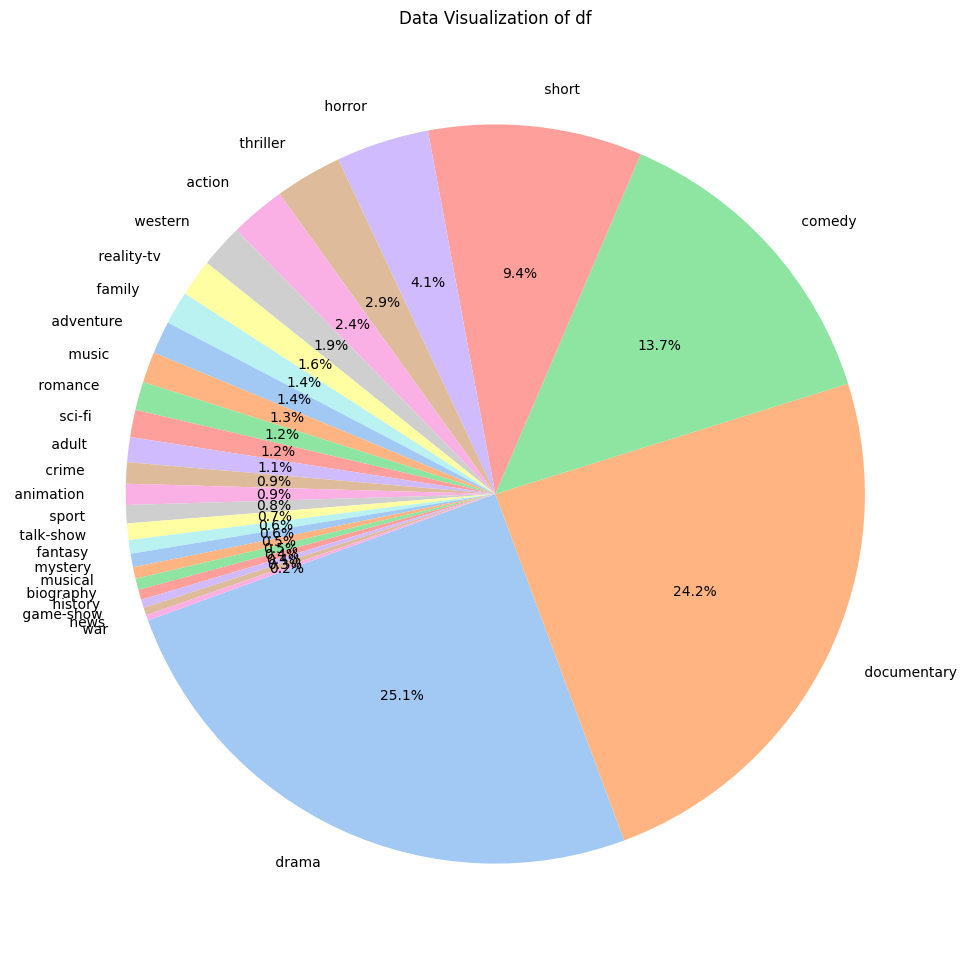

In [17]:
# Create a pie chart of genre distribution
plt.figure(figsize=(12, 12))
genre_counts = df["Genre"].value_counts()
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=200, colors=sns.color_palette('pastel'))
plt.title("Data Visualization of df")
plt.show()


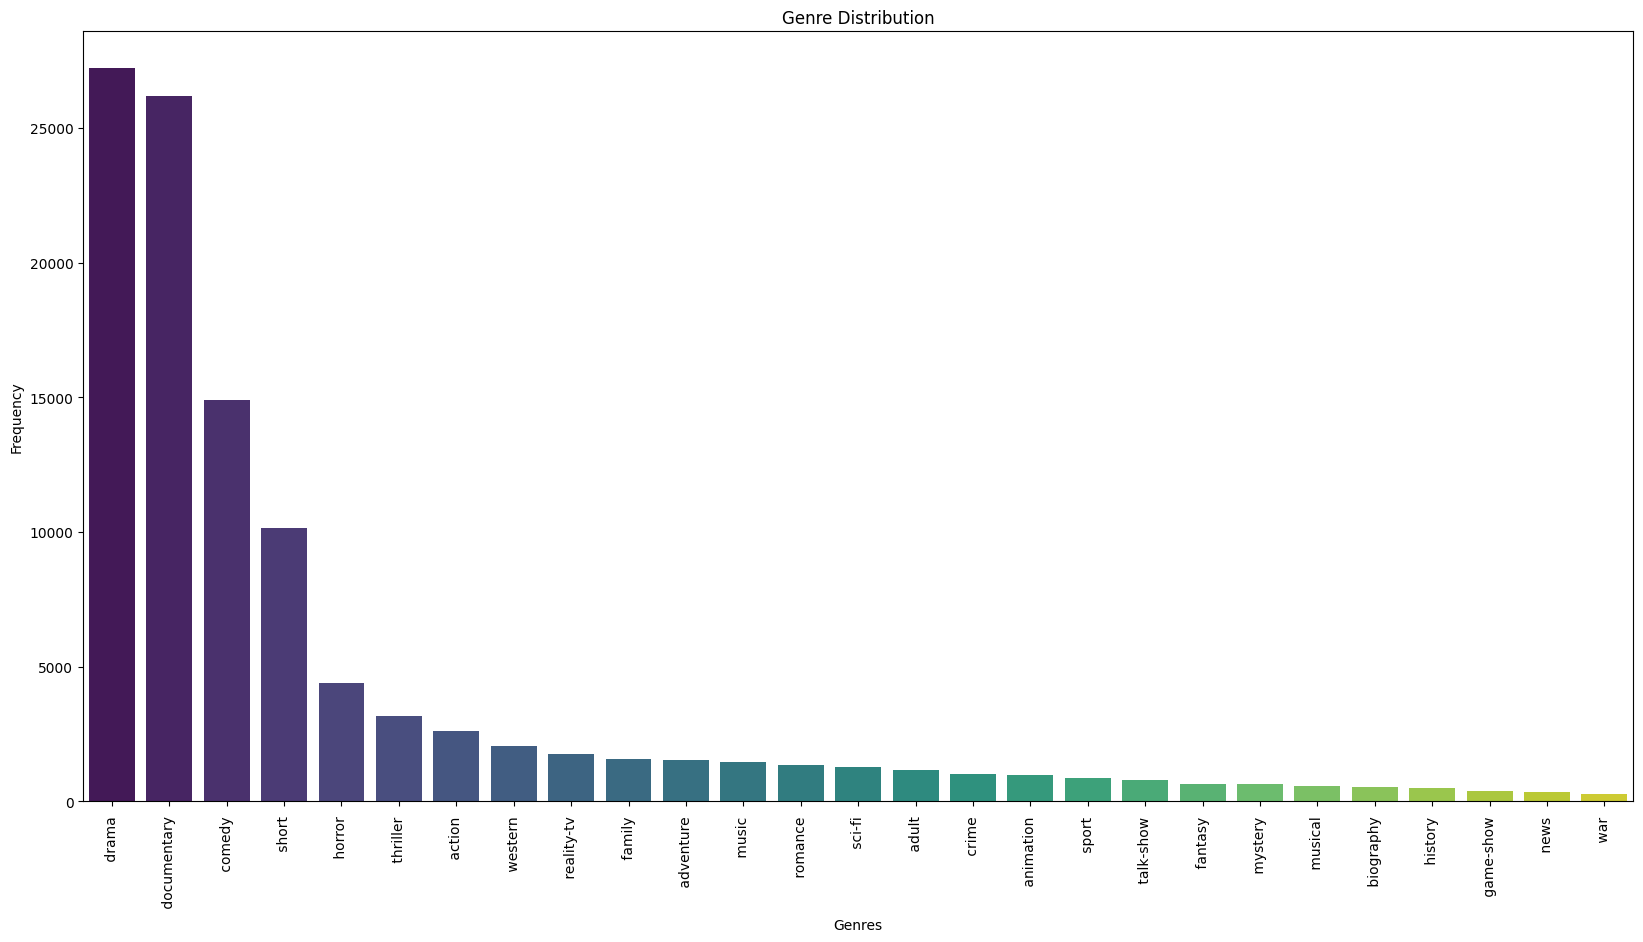

In [18]:
# Create a countplot for genre distribution
plt.figure(figsize=(20, 10))
sns.countplot(x='Genre', data=df, palette='viridis', order=df['Genre'].value_counts().index)
plt.title("Genre Distribution")
plt.xlabel("Genres")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [19]:
# remove id column from head
data=df.drop(["Title","id"], axis=1)
data
# The data is ready for training and testing 

,Genre,Description,Despcription_clean
0,drama,Listening in to a conversation between his do...,listening conversation doctor parent 10yearold...
1,thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
2,adult,As the bus empties the students for their fie...,bus empty student field trip museum natural hi...
3,drama,To help their unemployed father make ends mee...,help unemployed father make end meet edith twi...
4,drama,The film's title refers not only to the un-re...,film title refers unrecovered body ground zero...
...,...,...,...
54195,horror,"Covering multiple genres, Tales of Light & Da...",covering multiple genre tale light dark anthol...
54196,western,As Alice and Cora Munro attempt to find their...,alice cora munro attempt find father british o...
54197,adult,A movie 169 years in the making. Oliver Twist...,movie 169 year making oliver twist artful dodg...
54198,drama,"Popular, but mysterious rock D.J Mike Mallard...",popular mysterious rock dj mike mallard askew ...


In [20]:
label_encoder = LabelEncoder()
data['Genre_encoded'] = label_encoder.fit_transform(data['Genre'])
data['Genre_encoded']

encoded_genre_values = list(label_encoder.classes_)
encoded_genre_values

encoded_class_names = list(label_encoder.classes_)
print(encoded_class_names)

[' action ', ' adult ', ' adventure ', ' animation ', ' biography ', ' comedy ', ' crime ', ' documentary ', ' drama ', ' family ', ' fantasy ', ' game-show ', ' history ', ' horror ', ' music ', ' musical ', ' mystery ', ' news ', ' reality-tv ', ' romance ', ' sci-fi ', ' short ', ' sport ', ' talk-show ', ' thriller ', ' war ', ' western ']


In [21]:
data

,Genre,Description,Despcription_clean,Genre_encoded
0,drama,Listening in to a conversation between his do...,listening conversation doctor parent 10yearold...,8
1,thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,24
2,adult,As the bus empties the students for their fie...,bus empty student field trip museum natural hi...,1
3,drama,To help their unemployed father make ends mee...,help unemployed father make end meet edith twi...,8
4,drama,The film's title refers not only to the un-re...,film title refers unrecovered body ground zero...,8
...,...,...,...,...
54195,horror,"Covering multiple genres, Tales of Light & Da...",covering multiple genre tale light dark anthol...,13
54196,western,As Alice and Cora Munro attempt to find their...,alice cora munro attempt find father british o...,26
54197,adult,A movie 169 years in the making. Oliver Twist...,movie 169 year making oliver twist artful dodg...,1
54198,drama,"Popular, but mysterious rock D.J Mike Mallard...",popular mysterious rock dj mike mallard askew ...,8


In [22]:
## Split the data into 80:20
x = data["Despcription_clean"]
y = data["Genre"]

x_train ,x_test ,y_train ,y_test = train_test_split(x ,y ,test_size = 0.2)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
x_train = vectorizer.fit_transform(x_train)

# Transform the testing data
x_test = vectorizer.transform(x_test)



## Using TfidfVectorizer technique
# vectorizer = TfidfVectorizer()
# x_train = vectorize.fit_transform(x_train)
# x_test =  vectorize.transform(x_test)

### 3. Multinomial Naive Bayes

Model Score on Training data: 0.6260045427817044
Model Score on Testing data: 0.5251118387676982
Classification Report:
                precision    recall  f1-score   support

      action        0.06      0.77      0.10        39
       adult        0.02      0.31      0.03        13
   adventure        0.05      0.35      0.08        43
   animation        0.00      0.00      0.00         0
   biography        0.00      0.00      0.00         2
      comedy        0.47      0.54      0.50      2605
       crime        0.00      0.00      0.00         1
 documentary        0.89      0.57      0.69      8214
       drama        0.82      0.46      0.59      9584
      family        0.00      0.50      0.01         2
     fantasy        0.00      0.00      0.00         7
   game-show        0.12      1.00      0.22         9
     history        0.00      0.00      0.00         0
      horror        0.32      0.70      0.44       392
       music        0.08      0.85      0.15        2

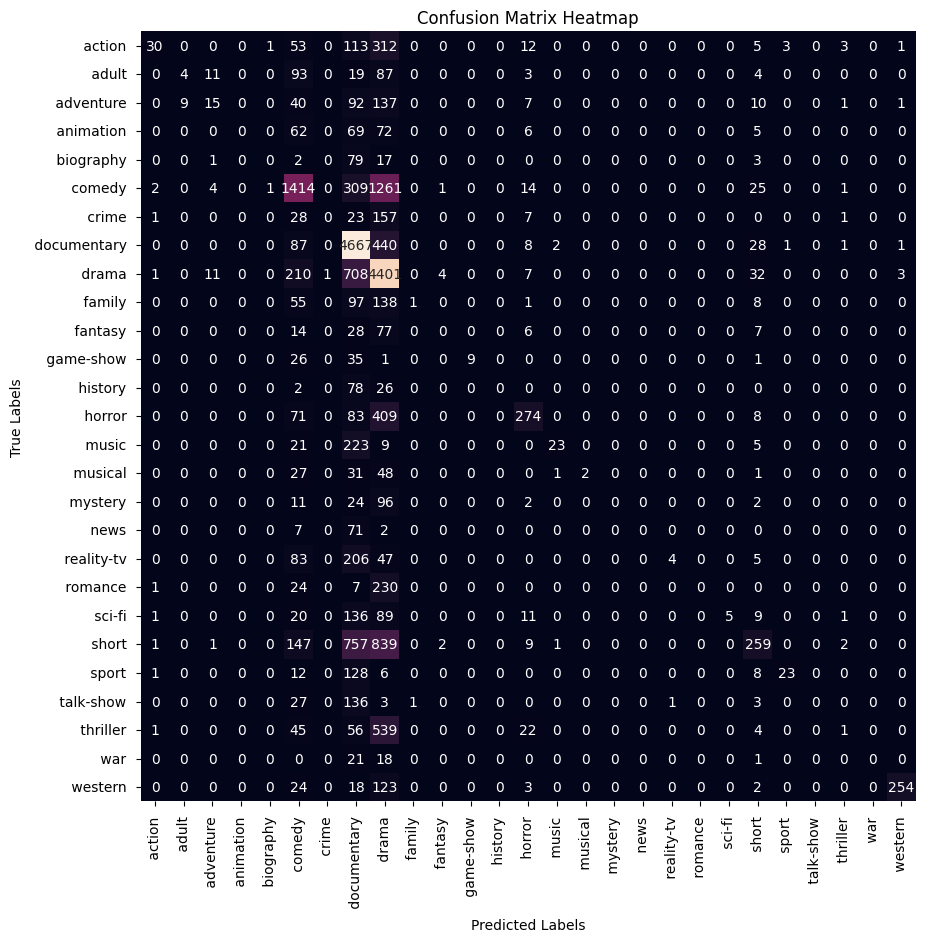

In [148]:
# Import required library for MNB
from sklearn.naive_bayes import MultinomialNB

# Create and train the Multinomial Naive Bayes model
mnb = MultinomialNB()
mnb.fit(x_train, y_train)

# Evaluate model performance on the training data
train_score = mnb.score(x_train, y_train)
print("Model Score on Training data:", train_score)

# Evaluate model performance on the testing data
test_score = mnb.score(x_test, y_test)
print("Model Score on Testing data:", test_score)

# Make predictions on the testing data
y_pred = mnb.predict(x_test)

# Display classification report
print("Classification Report:\n", classification_report(y_pred, y_test))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

### 4. Support Vector Machine (SVM)

Model Score on Training data: 0.998858539622511
Model Score on Testing data: 0.5161186182723793
Classification Report:
                precision    recall  f1-score   support

      action        0.30      0.33      0.31       479
       adult        0.42      0.48      0.45       193
   adventure        0.23      0.27      0.25       265
   animation        0.15      0.28      0.20       118
   biography        0.00      0.00      0.00        58
      comedy        0.53      0.52      0.52      3086
       crime        0.12      0.17      0.14       151
 documentary        0.71      0.69      0.70      5394
       drama        0.60      0.54      0.57      5927
      family        0.15      0.18      0.17       252
     fantasy        0.08      0.12      0.10        92
   game-show        0.58      0.70      0.64        60
     history        0.06      0.11      0.07        55
      horror        0.58      0.54      0.56       913
       music        0.49      0.54      0.51       259

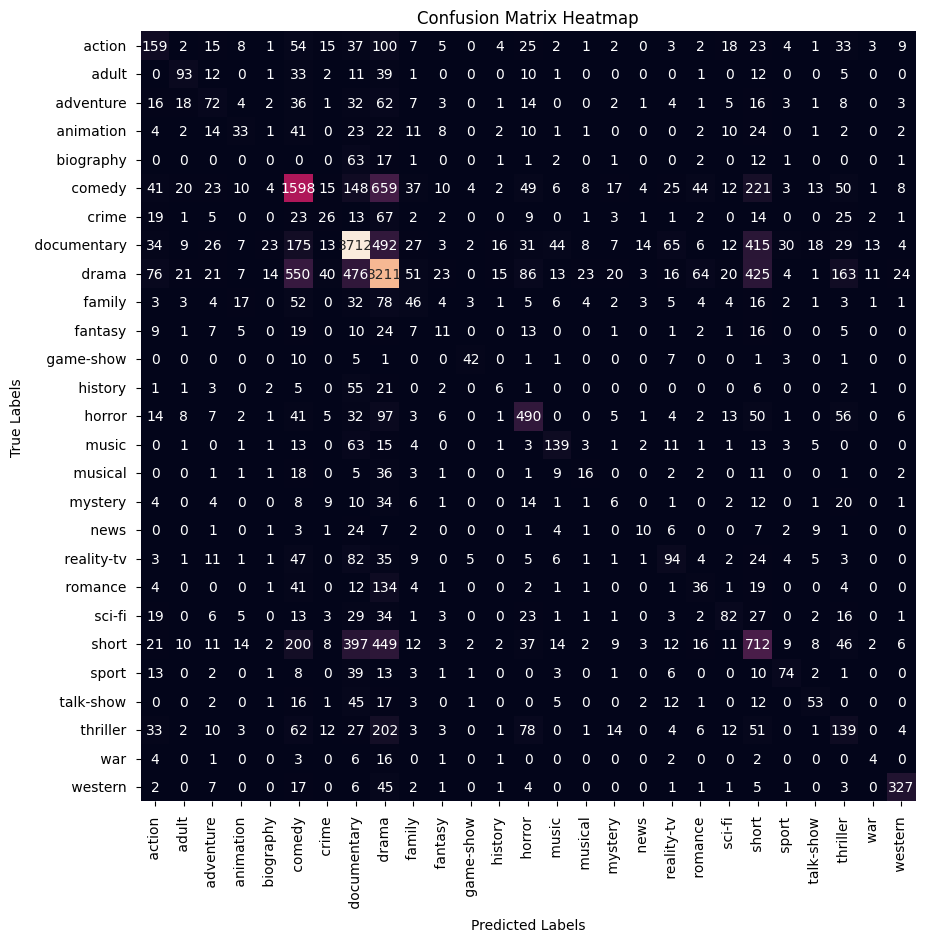

In [152]:
# Import required library for SVM
from sklearn.svm import LinearSVC
# Create and train the Linear Support Vector Classifier (SVM) model
svm = LinearSVC()
svm.fit(x_train, y_train)

# Evaluate model performance on the training data
train_score = svm.score(x_train, y_train)
print("Model Score on Training data:", train_score)

# Evaluate model performance on the testing data
test_score = svm.score(x_test, y_test)
print("Model Score on Testing data:", test_score)

# Make predictions on the testing data
y_pred = svm.predict(x_test)

# Display classification report
print("Classification Report:\n", classification_report(y_pred, y_test))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

### 5. Logistic Regression

Logistic Regression - Train Score: 0.9690191511685556
Logistic Regression - Test Score: 0.5689249642577134
Classification Report:
                precision    recall  f1-score   support

      action        0.31      0.38      0.34       443
       adult        0.42      0.60      0.49       156
   adventure        0.24      0.36      0.28       208
   animation        0.19      0.37      0.25       108
   biography        0.01      0.06      0.02        17
      comedy        0.59      0.55      0.57      3229
       crime        0.10      0.20      0.13       104
 documentary        0.77      0.71      0.74      5719
       drama        0.68      0.57      0.62      6475
      family        0.19      0.27      0.22       214
     fantasy        0.08      0.19      0.11        52
   game-show        0.57      0.80      0.67        51
     history        0.04      0.21      0.06        19
      horror        0.64      0.62      0.63       866
       music        0.55      0.60      0.5

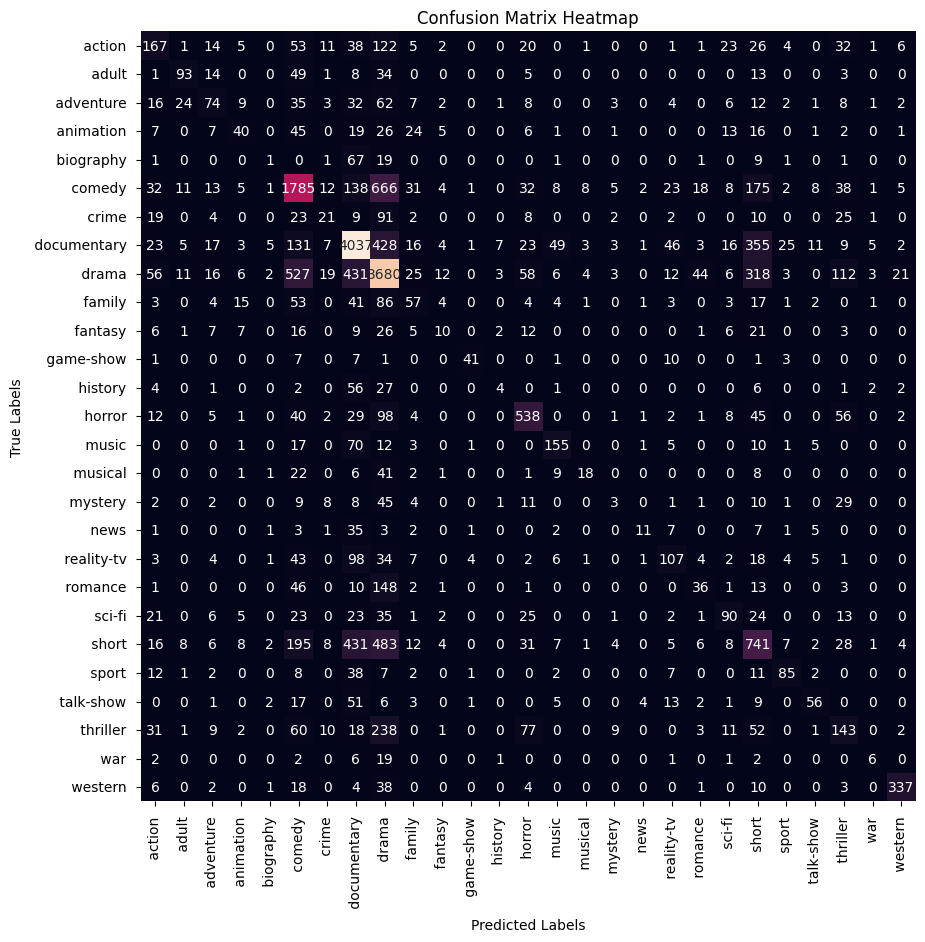

In [154]:
# Import required library for LogisticRegression
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
model = LogisticRegression()

# Train the Logistic Regression model
model.fit(x_train, y_train)

# Evaluate model performance on the training data
train_score = model.score(x_train, y_train)
print("Logistic Regression - Train Score:", train_score)

# Evaluate model performance on the testing data
test_score = model.score(x_test, y_test)
print("Logistic Regression - Test Score:", test_score)

# Make predictions on the testing data
y_pred = model.predict(x_test)

# Display classification report
print("Classification Report:\n", classification_report(y_pred, y_test))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

### 6. RandomForest

Random Forest - Train Score: 0.9995388038878832
Random Forest - Test Score: 0.4885394087534013
Classification Report:
                precision    recall  f1-score   support

      action        0.01      0.60      0.01         5
       adult        0.06      0.76      0.11        17
   adventure        0.12      0.75      0.21        52
   animation        0.00      0.00      0.00         1
   biography        0.00      0.00      0.00         1
      comedy        0.27      0.56      0.36      1449
       crime        0.00      1.00      0.01         1
 documentary        0.88      0.56      0.68      8316
       drama        0.84      0.41      0.55     11133
      family        0.02      0.71      0.03         7
     fantasy        0.00      0.00      0.00         2
   game-show        0.46      0.94      0.62        35
     history        0.00      0.00      0.00         1
      horror        0.15      0.81      0.25       155
       music        0.16      0.88      0.27        50


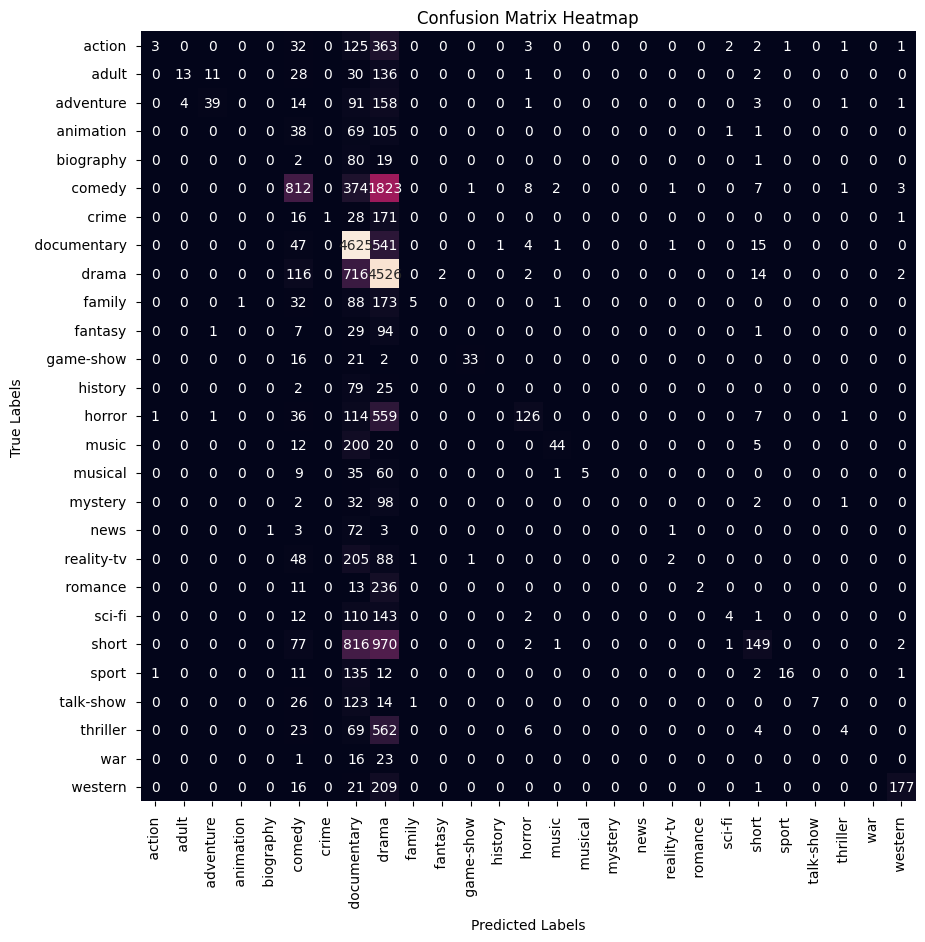

In [155]:
# Import required library for Random Forest
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
random_forest = RandomForestClassifier()

# Fit the model using GridSearchCV
random_forest.fit(x_train, y_train)

# Evaluate model performance on the training data
train_score = random_forest.score(x_train, y_train)
print("Random Forest - Train Score:", train_score)

# Evaluate model performance on the testing data
test_score = random_forest.score(x_test, y_test)
print("Random Forest - Test Score:", test_score)

# Make predictions on the testing data
y_pred = random_forest.predict(x_test)

# Display classification report
print("Classification Report:\n", classification_report(y_pred, y_test))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()